# Install Library

In [ ]:
# Install library yang tidak ada secara default di Colab
!pip install pretty_midi librosa wordcloud

  Using cached pretty_midi-0.2.11-py3-none-any.whl
  Using cached mido-1.3.3-py3-none-any.whl.metadata (6.4 kB)
Using cached mido-1.3.3-py3-none-any.whl (54 kB)


#Load Data

In [ ]:
import os
import zipfile
import shutil
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import pretty_midi
from wordcloud import WordCloud

BASE_DIR = '/content'
EXTRACT_DIR = '/content/dataset_mirex'

# Nama file yang Anda upload
zip_lyrics_path = os.path.join(BASE_DIR, 'Lyrics.zip')
zip_audio_path  = os.path.join(BASE_DIR, 'Audio.zip')
zip_midi_path   = os.path.join(BASE_DIR, 'MIDIs.zip')
bat_file_path   = os.path.join(BASE_DIR, 'split-by-categories-lyrics.bat')

# Buat folder tujuan utama
os.makedirs(EXTRACT_DIR, exist_ok=True)

# --- FUNGSI UNZIP ---
def unzip_file(zip_path, folder_name):
    target_path = os.path.join(EXTRACT_DIR, folder_name)

    if os.path.exists(zip_path):
        print(f"Sedang mengekstrak {os.path.basename(zip_path)}...")
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(EXTRACT_DIR)
            # Cek apakah hasil ekstrak membuat folder yang sesuai
            # (Kadang zip membungkus folder, kadang langsung file)
            print(f"Berhasil diekstrak.")
        except zipfile.BadZipFile:
            print(f"Error: File {os.path.basename(zip_path)} rusak atau belum selesai upload.")
    else:
        print(f"Peringatan: File {os.path.basename(zip_path)} tidak ditemukan. Pastikan sudah di-upload.")

# 1. Eksekusi Unzip
unzip_file(zip_lyrics_path, 'Lyrics')
unzip_file(zip_audio_path, 'Audio')
unzip_file(zip_midi_path, 'MIDs')

# 2. Pindahkan file .bat ke dalam folder dataset agar rapi
if os.path.exists(bat_file_path):
    target_bat = os.path.join(EXTRACT_DIR, 'split-by-categories-lyrics.bat')
    shutil.copy(bat_file_path, target_bat)
    print(f"File .bat disalin ke folder dataset.")
else:
    print(f"File .bat tidak ditemukan. Pastikan sudah di-upload.")

PATH_LYRICS = os.path.join(EXTRACT_DIR, 'Lyrics')
PATH_AUDIO = os.path.join(EXTRACT_DIR, 'Audio')
PATH_MIDI = os.path.join(EXTRACT_DIR, 'MIDIs')
PATH_BAT = os.path.join(EXTRACT_DIR, 'split-by-categories-lyrics.bat')

print("\n" + "="*30)
print("SETUP SELESAI. PATH DATA ANDA:")
print("="*30)
print(f"Lirik Path : {PATH_LYRICS}")
print(f"Audio Path : {PATH_AUDIO}")
print(f"MIDI Path  : {PATH_MIDI}")
print(f"Label Path : {PATH_BAT}")

# Cek Validasi Sederhana
if os.path.exists(PATH_LYRICS):
    print(f"\nJumlah file Lirik ditemukan: {len(os.listdir(PATH_LYRICS))}")
else:
    print("\nFolder Lirik belum terbentuk sempurna.")

if os.path.exists(PATH_AUDIO):
    print(f"Jumlah file Audio ditemukan: {len(os.listdir(PATH_AUDIO))}")

Sedang mengekstrak Lyrics.zip...
Berhasil diekstrak.
Sedang mengekstrak Audio.zip...
Berhasil diekstrak.
Sedang mengekstrak MIDIs.zip...
Berhasil diekstrak.
File .bat disalin ke folder dataset.

SETUP SELESAI. PATH DATA ANDA:
Lirik Path : /content/dataset_mirex/Lyrics
Audio Path : /content/dataset_mirex/Audio
MIDI Path  : /content/dataset_mirex/MIDIs
Label Path : /content/dataset_mirex/split-by-categories-lyrics.bat

Jumlah file Lirik ditemukan: 764
Jumlah file Audio ditemukan: 903


#1. Parsing Label dan Emosi

Membaca label dari: /content/dataset_mirex/split-by-categories-lyrics.bat
Label berhasil dimuat: 903 data.


/tmp/ipython-input-1483133789.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='emotion', data=labels_df, order=sorted(labels_df['emotion'].unique()), palette='viridis')


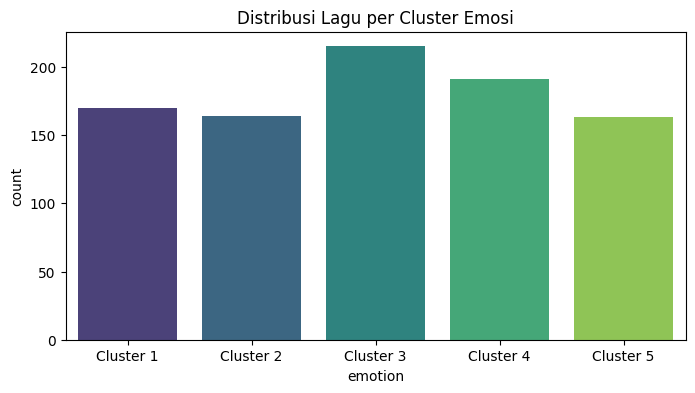

In [ ]:
label_data = []
pattern = re.compile(r'move (\d+)\.txt "([^\\]+)\\.*')

if os.path.exists(PATH_BAT):
    print(f"Membaca label dari: {PATH_BAT}")
    with open(PATH_BAT, 'r') as f:
        for line in f:
            match = pattern.search(line)
            if match:
                label_data.append({
                    'file_id': match.group(1),
                    'emotion': match.group(2) # Cluster 1, Cluster 2, dst
                })
    labels_df = pd.DataFrame(label_data)
    print(f"Label berhasil dimuat: {len(labels_df)} data.")

    # Visualisasi Distribusi Label
    plt.figure(figsize=(8, 4))
    sns.countplot(x='emotion', data=labels_df, order=sorted(labels_df['emotion'].unique()), palette='viridis')
    plt.title('Distribusi Lagu per Cluster Emosi')
    plt.show()
else:
    print(f"File label tidak ditemukan di {PATH_BAT}")
    labels_df = pd.DataFrame(columns=['file_id', 'emotion'])

#2. EDA Modalitas Lirik

##Mengecek panjang, kelengkapan dan distribusi data.

Memuat data lirik...
Total Data Valid: 764
Lirik Sangat Pendek (<10 kata): 0 file


/tmp/ipython-input-3932968086.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='emotion', y='word_count', data=df_lyric_eda, palette='viridis')


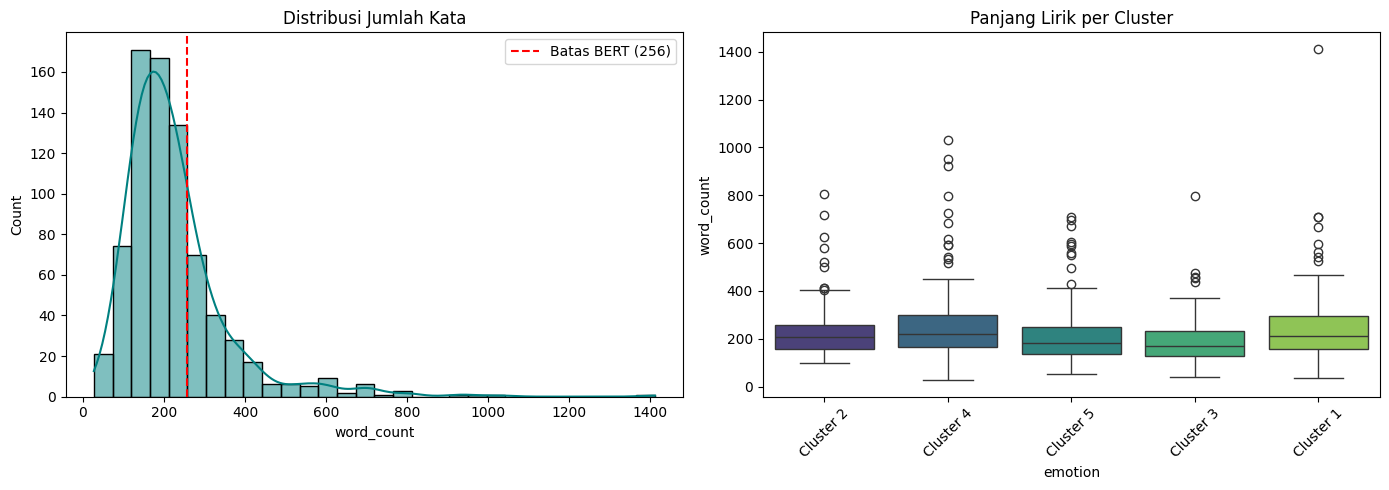

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob

# 1. Muat Data Lirik & Gabung dengan Label
print("Memuat data lirik...")
lyric_data = []
if os.path.exists(PATH_LYRICS):
    for f in glob.glob(os.path.join(PATH_LYRICS, '*.txt')):
        fid = os.path.splitext(os.path.basename(f))[0]
        try:
            with open(f, 'r', encoding='utf-8') as txt:
                text = txt.read().strip() # Hapus spasi awal/akhir
                if text: # Hanya ambil jika tidak kosong
                    lyric_data.append({'file_id': fid, 'text': text})
        except:
            pass

df_lyric_eda = pd.DataFrame(lyric_data)
# Gabung dengan labels_df (yang sudah dibuat di langkah sebelumnya)
df_lyric_eda = pd.merge(df_lyric_eda, labels_df, on='file_id', how='inner')

print(f"Total Data Valid: {len(df_lyric_eda)}")

# 2. Feature Engineering Dasar
# Hitung jumlah baris (line count)
df_lyric_eda['line_count'] = df_lyric_eda['text'].apply(lambda x: len(x.split('\n')))
# Hitung jumlah kata (word count)
df_lyric_eda['word_count'] = df_lyric_eda['text'].apply(lambda x: len(x.split()))
# Hitung jumlah karakter
df_lyric_eda['char_count'] = df_lyric_eda['text'].apply(len)

# 3. Cek Data Bermasalah (Terlalu Pendek)
short_lyrics = df_lyric_eda[df_lyric_eda['word_count'] < 10]
print(f"Lirik Sangat Pendek (<10 kata): {len(short_lyrics)} file")
if len(short_lyrics) > 0:
    print(short_lyrics[['file_id', 'word_count', 'emotion']].head())

# 4. Visualisasi Distribusi Panjang Lirik
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_lyric_eda['word_count'], bins=30, kde=True, color='teal')
plt.axvline(x=256, color='r', linestyle='--', label='Batas BERT (256)')
plt.title('Distribusi Jumlah Kata')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(x='emotion', y='word_count', data=df_lyric_eda, palette='viridis')
plt.title('Panjang Lirik per Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Melihat "kepadatan" bahasa dan seberapa bersih datanya.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


--- Statistik Kebahasaan ---
Rata-rata Stopword Ratio: 46.95%
Rata-rata Vocab Richness (TTR): 0.46


/tmp/ipython-input-3748726280.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='emotion', y='ttr', data=df_lyric_eda, palette='coolwarm')


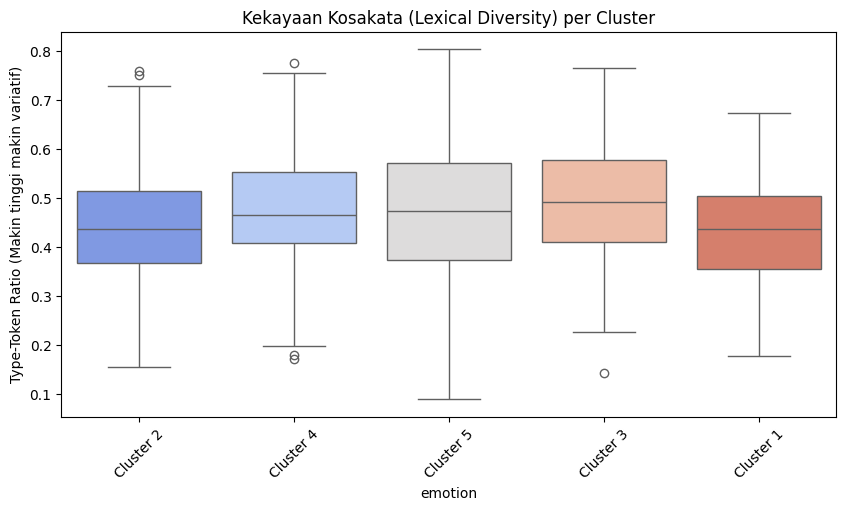

In [ ]:
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fungsi hitung stopword & unique words
def analyze_text(text):
    words = text.lower().split()
    # Hitung stopwords
    stop_count = len([w for w in words if w in stop_words])
    # Hitung unique words (vocab richness)
    vocab_size = len(set(words))
    return stop_count, vocab_size

# Terapkan
df_lyric_eda[['stopword_count', 'vocab_size']] = df_lyric_eda['text'].apply(
    lambda x: pd.Series(analyze_text(x))
)

# Hitung Rasio
df_lyric_eda['stopword_ratio'] = df_lyric_eda['stopword_count'] / df_lyric_eda['word_count']
df_lyric_eda['ttr'] = df_lyric_eda['vocab_size'] / df_lyric_eda['word_count'] # Type-Token Ratio

print("--- Statistik Kebahasaan ---")
print(f"Rata-rata Stopword Ratio: {df_lyric_eda['stopword_ratio'].mean()*100:.2f}%")
print(f"Rata-rata Vocab Richness (TTR): {df_lyric_eda['ttr'].mean():.2f}")

# Visualisasi TTR per Cluster (Apakah lagu sedih kosakatanya lebih sedikit?)
plt.figure(figsize=(10, 5))
sns.boxplot(x='emotion', y='ttr', data=df_lyric_eda, palette='coolwarm')
plt.title('Kekayaan Kosakata (Lexical Diversity) per Cluster')
plt.ylabel('Type-Token Ratio (Makin tinggi makin variatif)')
plt.xticks(rotation=45)
plt.show()

## Melihat kata kunci khas tiap cluster

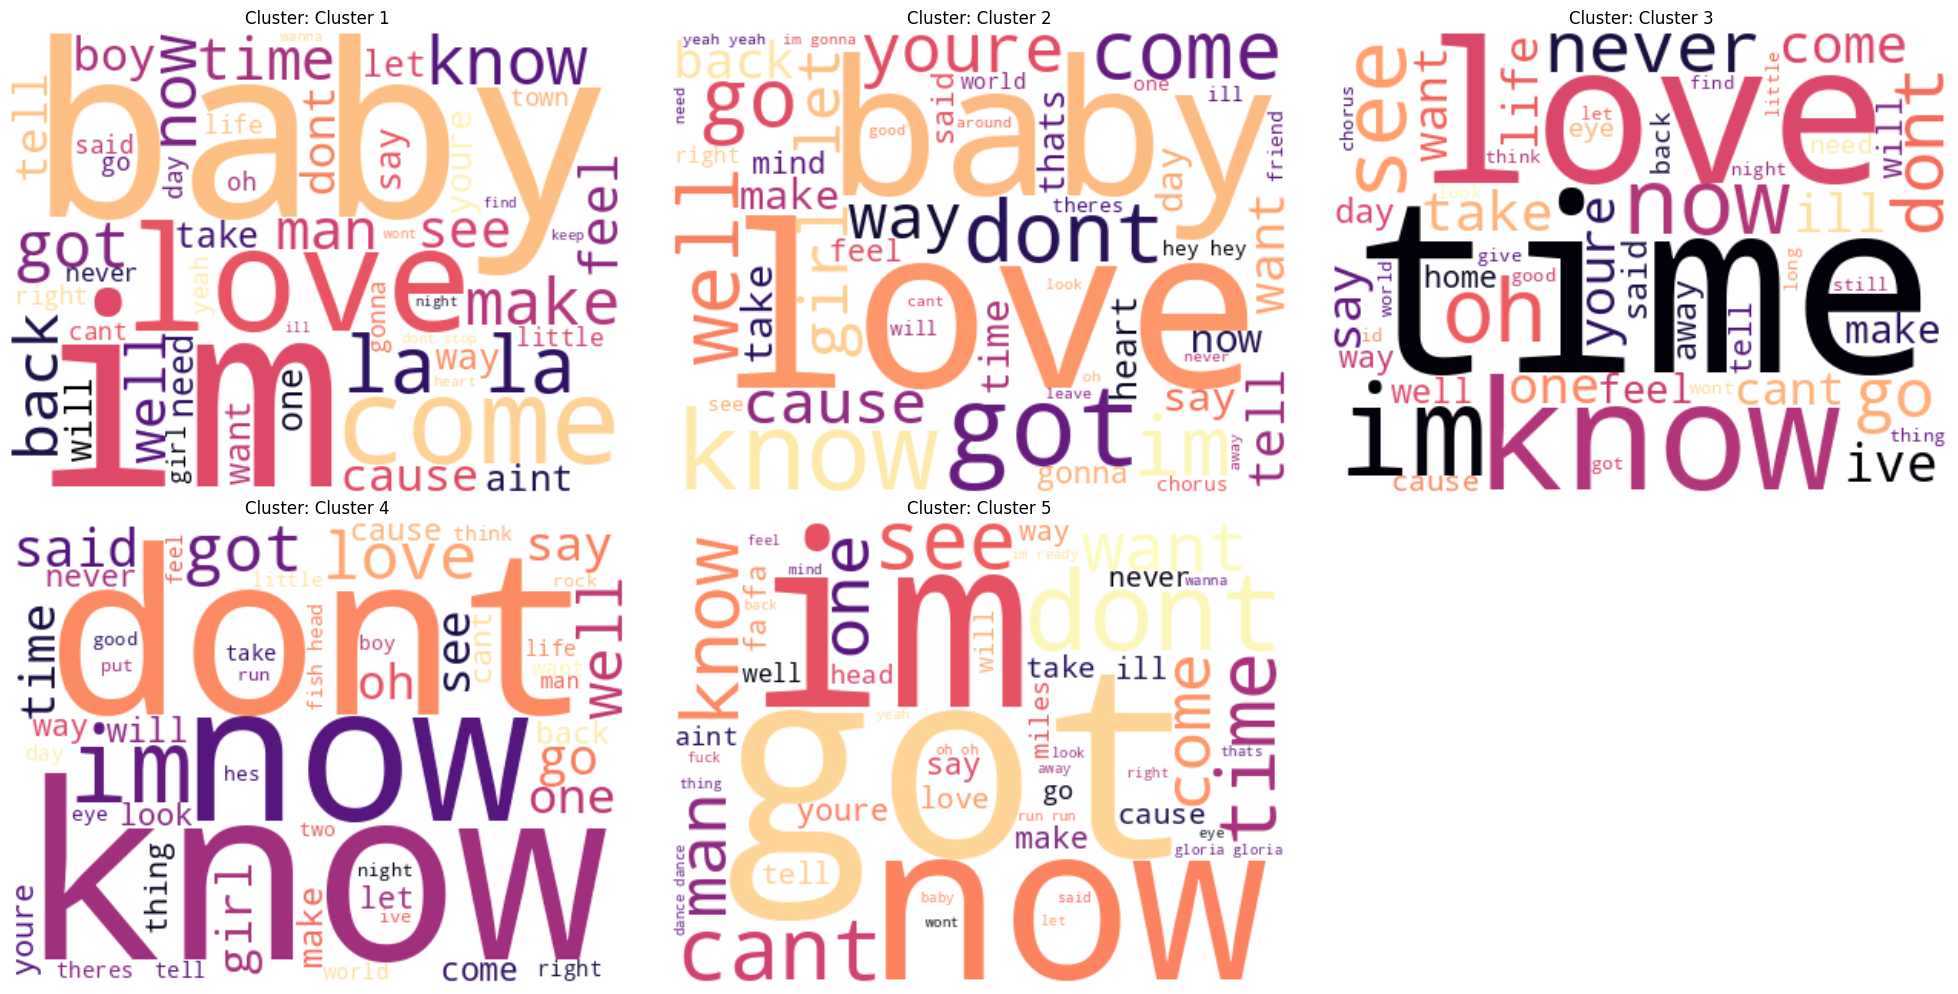


--- Top 5 Frasa (Bigram) per Cluster ---
[Cluster 1]: la la, dont stop, boys town, rock rock, think think
[Cluster 2]: hey hey, im gonna, shake love, yeah yeah, good times
[Cluster 3]: everybody knows, dont know, la la, ive got, dont care
[Cluster 4]: fish heads, dont know, rock roll, bird bird, oh yeah
[Cluster 5]: fa fa, miles miles, gloria gloria, oh oh, run run


In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# Fungsi untuk membersihkan teks sederhana
def simple_clean(text):
    text = text.lower()
    text = ''.join([c for c in text if c not in string.punctuation]) # Hapus tanda baca
    return text

df_lyric_eda['clean_text'] = df_lyric_eda['text'].apply(simple_clean)

# 1. Word Cloud per Cluster
unique_clusters = sorted(df_lyric_eda['emotion'].unique())

plt.figure(figsize=(20, 10))
for i, cluster in enumerate(unique_clusters):
    subset = df_lyric_eda[df_lyric_eda['emotion'] == cluster]
    text_cluster = " ".join(subset['clean_text'])

    # Generate WC
    wc = WordCloud(width=400, height=300, background_color='white', max_words=50, colormap='magma').generate(text_cluster)

    plt.subplot(2, 3, i+1) # Asumsi max 6 cluster
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"Cluster: {cluster}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# 2. Analisis Bigram (Top Frasa per Cluster)
def get_top_bigrams(text_list, n=5):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text_list)
    bag_of_words = vec.transform(text_list)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

print("\n--- Top 5 Frasa (Bigram) per Cluster ---")
for cluster in unique_clusters:
    subset = df_lyric_eda[df_lyric_eda['emotion'] == cluster]
    top_bi = get_top_bigrams(subset['clean_text'])
    print(f"[{cluster}]: {', '.join([x[0] for x in top_bi])}")

## Analisis Sentimen (Validasi Label)

--- Rata-rata Sentimen per Cluster ---
emotion
Cluster 5    0.019899
Cluster 3    0.071177
Cluster 1    0.077642
Cluster 4    0.077894
Cluster 2    0.147365
Name: sentiment, dtype: float64


/tmp/ipython-input-3063736811.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='emotion', y='sentiment', data=df_lyric_eda, palette='RdBu')


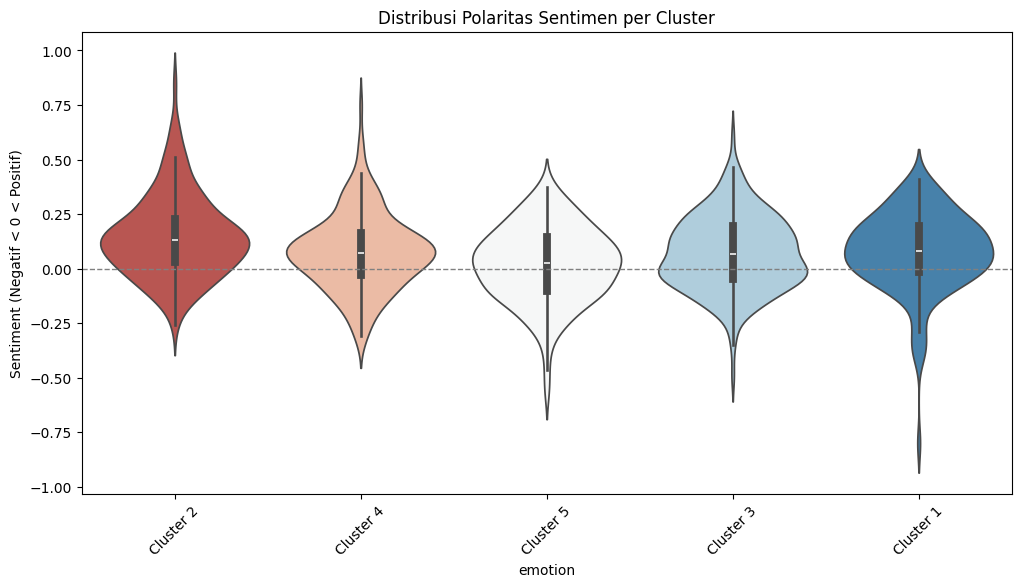


💡 Cara Baca Grafik:
- Nilai > 0: Lirik cenderung Positif (Bahagia, Harapan).
- Nilai < 0: Lirik cenderung Negatif (Sedih, Marah).
- Cek apakah 'Cluster 3' (biasanya sedih) berada di bawah garis 0.



In [ ]:
from textblob import TextBlob

# Fungsi hitung polaritas (-1 s/d +1)
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df_lyric_eda['sentiment'] = df_lyric_eda['clean_text'].apply(get_sentiment)

print("--- Rata-rata Sentimen per Cluster ---")
print(df_lyric_eda.groupby('emotion')['sentiment'].mean().sort_values())

# Visualisasi Sentimen
plt.figure(figsize=(12, 6))
sns.violinplot(x='emotion', y='sentiment', data=df_lyric_eda, palette='RdBu')
plt.axhline(0, color='grey', linestyle='--', linewidth=1)
plt.title('Distribusi Polaritas Sentimen per Cluster')
plt.ylabel('Sentiment (Negatif < 0 < Positif)')
plt.xticks(rotation=45)
plt.show()

# Interpretasi Singkat
print("""
💡 Cara Baca Grafik:
- Nilai > 0: Lirik cenderung Positif (Bahagia, Harapan).
- Nilai < 0: Lirik cenderung Negatif (Sedih, Marah).
- Cek apakah 'Cluster 3' (biasanya sedih) berada di bawah garis 0.
""")

#3. EDA Modalitas Audio

## Ekstraksi Fitur Massa

In [ ]:
import librosa
import numpy as np
import pandas as pd
import glob
import os
import time

# List untuk menyimpan data
audio_features = []

# Ambil semua file mp3
audio_files = glob.glob(os.path.join(PATH_AUDIO, '*.mp3'))

start_time = time.time()

for f in audio_files:
    fid = os.path.splitext(os.path.basename(f))[0]
    try:
        # Load audio (ambil 30 detik pertama agar cepat & konsisten)
        y, sr = librosa.load(f, sr=None, duration=30.0)

        # 1. Fitur Struktural
        duration = librosa.get_duration(y=y, sr=sr)

        # 2. Fitur Ritme (Tempo)
        # hop_length=512 adalah standar
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)

        # 3. Fitur Energi/Loudness (RMS Energy)
        rms = librosa.feature.rms(y=y)
        rms_mean = np.mean(rms)

        # 4. Fitur Timbre/Warna Suara (Spectral Centroid - Kecerahan)
        # Centroid tinggi = suara 'tajam'/'bright' (misal: teriak, gitar distorsi)
        # Centroid rendah = suara 'warm'/'dark' (misal: piano pelan, bass)
        cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        cent_mean = np.mean(cent)

        # 5. Zero Crossing Rate (Kekasaran/Noise)
        zcr = librosa.feature.zero_crossing_rate(y=y)
        zcr_mean = np.mean(zcr)

        audio_features.append({
            'file_id': fid,
            'duration': duration,
            'tempo': tempo[0] if isinstance(tempo, np.ndarray) else tempo,
            'rms_energy': rms_mean,
            'spectral_centroid': cent_mean,
            'zero_crossing_rate': zcr_mean
        })

    except Exception as e:
        print(f"Gagal memproses {fid}: {e}")

# Buat DataFrame & Gabung dengan Label
df_audio_eda = pd.DataFrame(audio_features)
# Pastikan labels_df sudah ada dari langkah sebelumnya
if 'labels_df' in globals():
    df_audio_eda = pd.merge(df_audio_eda, labels_df, on='file_id', how='inner')

print(f"\Selesai! Waktu proses: {time.time() - start_time:.2f} detik.")
print(f"Total Data Audio Valid: {len(df_audio_eda)}")
print(df_audio_eda.head())

<>:62: SyntaxWarning: invalid escape sequence '\S'
<>:62: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-4106806561.py:62: SyntaxWarning: invalid escape sequence '\S'
  print(f"\Selesai! Waktu proses: {time.time() - start_time:.2f} detik.")
/tmp/ipython-input-4106806561.py:28: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)


\Selesai! Waktu proses: 367.39 detik.
Total Data Audio Valid: 903
  file_id   duration       tempo  rms_energy  spectral_centroid  \
0     836  29.767982  109.956782    0.193146        2233.056207   
1     018  29.721542  126.048018    0.103676        3428.034084   
2     634  29.582222  120.185320    0.136085        2432.107701   
3     528  29.675102  132.512019    0.078929        1356.281876   
4     839  29.675102  135.999178    0.118421        2869.760307   

   zero_crossing_rate    emotion  
0            0.061778  Cluster 5  
1            0.109912  Cluster 1  
2            0.074426  Cluster 4  
3            0.027592  Cluster 3  
4            0.082564  Cluster 5  


## Visualisasi Statistik (Tempo, Energi, Durasi)

/tmp/ipython-input-2931946898.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='emotion', y='tempo', data=df_audio_eda, order=order_cls, palette='Reds')
/tmp/ipython-input-2931946898.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='emotion', y='rms_energy', data=df_audio_eda, order=order_cls, palette='Oranges')
/tmp/ipython-input-2931946898.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='emotion', y='spectral_centroid', data=df_audio_eda, order=order_cls, palette='Purples')


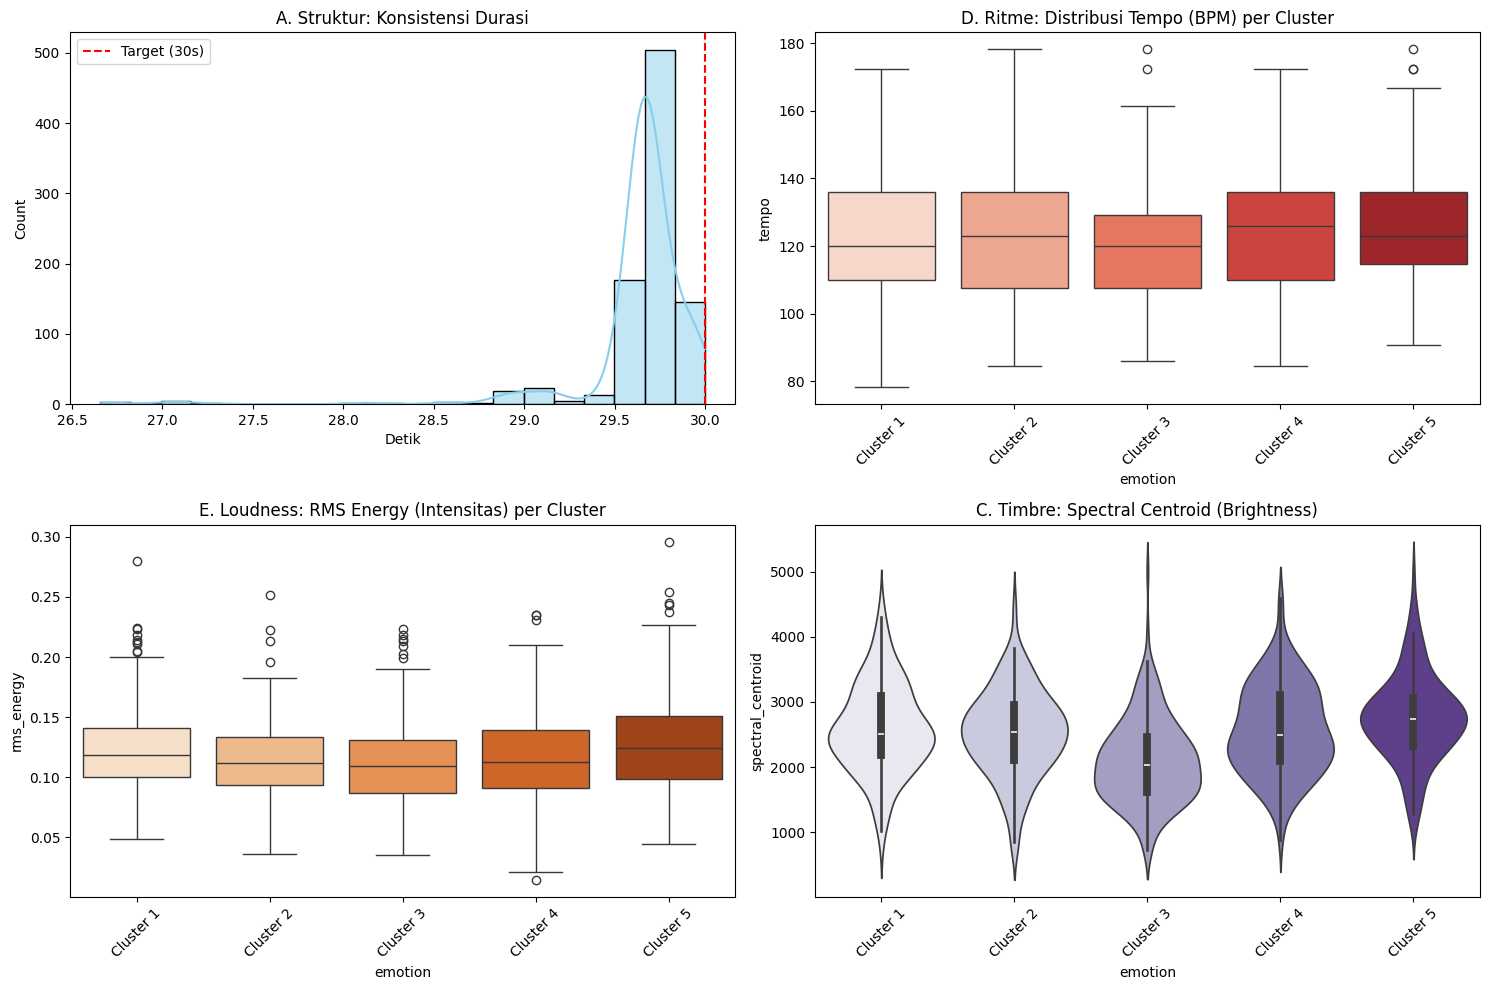

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

order_cls = sorted(df_audio_eda['emotion'].unique())

plt.figure(figsize=(15, 10))

# 1. Distribusi Durasi (Quality Check)
plt.subplot(2, 2, 1)
sns.histplot(df_audio_eda['duration'], bins=20, kde=True, color='skyblue')
plt.axvline(x=30, color='r', linestyle='--', label='Target (30s)')
plt.title('A. Struktur: Konsistensi Durasi')
plt.xlabel('Detik')
plt.legend()

# 2. Tempo vs Emosi (Ritme)
plt.subplot(2, 2, 2)
sns.boxplot(x='emotion', y='tempo', data=df_audio_eda, order=order_cls, palette='Reds')
plt.title('D. Ritme: Distribusi Tempo (BPM) per Cluster')
plt.xticks(rotation=45)

# 3. RMS Energy vs Emosi (Loudness/Dynamics)
# Cluster 1/5 harusnya lebih tinggi dari Cluster 3
plt.subplot(2, 2, 3)
sns.boxplot(x='emotion', y='rms_energy', data=df_audio_eda, order=order_cls, palette='Oranges')
plt.title('E. Loudness: RMS Energy (Intensitas) per Cluster')
plt.xticks(rotation=45)

# 4. Spectral Centroid vs Emosi (Timbre)
# Suara "Cerah/Tajam" vs "Gelap/Mendam"
plt.subplot(2, 2, 4)
sns.violinplot(x='emotion', y='spectral_centroid', data=df_audio_eda, order=order_cls, palette='Purples')
plt.title('C. Timbre: Spectral Centroid (Brightness)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Visualisasi Sinyal per Kelas (Mel-Spectrogram)

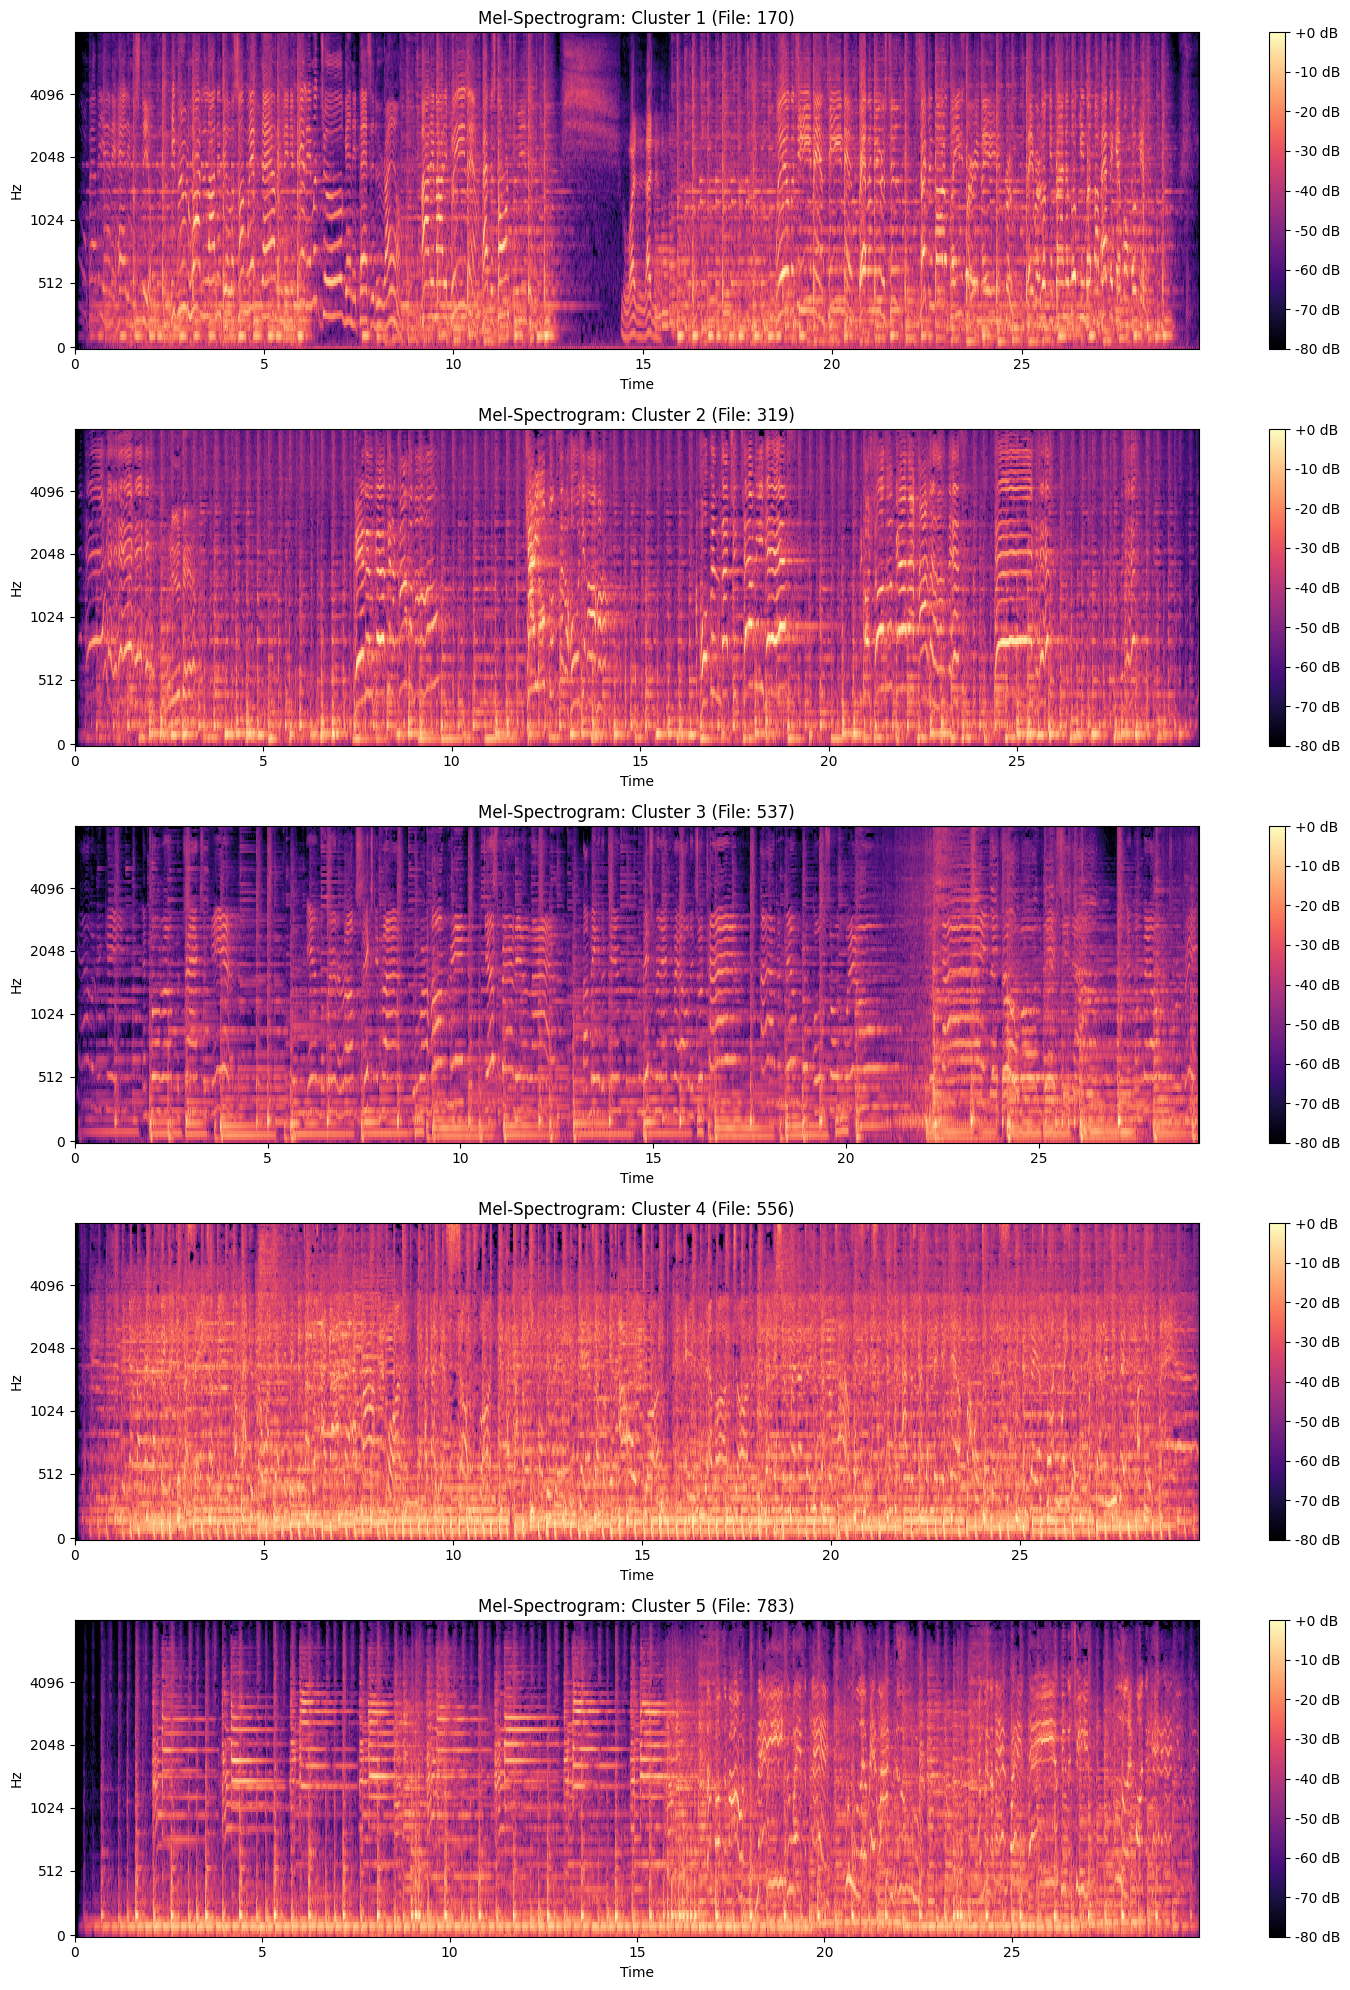

In [ ]:
import librosa.display

# Ambil 1 contoh file ID untuk setiap cluster unik
unique_clusters = sorted(df_audio_eda['emotion'].unique())

plt.figure(figsize=(15, 4 * len(unique_clusters)))

for i, cluster in enumerate(unique_clusters):
    # Ambil 1 file acak dari cluster ini
    sample_row = df_audio_eda[df_audio_eda['emotion'] == cluster].sample(1).iloc[0]
    fid = sample_row['file_id']

    # Cari path file aslinya
    # Kita asumsikan extension .mp3
    path = os.path.join(PATH_AUDIO, f"{fid}.mp3")

    if os.path.exists(path):
        y, sr = librosa.load(path, sr=None, duration=30) # Load 30 detik

        # Hitung Mel-Spectrogram
        # Ini adalah representasi yang paling mirip dengan cara manusia mendengar
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Plot
        ax = plt.subplot(len(unique_clusters), 1, i + 1)
        img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax)
        ax.set_title(f'Mel-Spectrogram: {cluster} (File: {fid})')
        plt.colorbar(img, format='%+2.0f dB')

plt.tight_layout()
plt.show()

#4. EDA Modalitas MIDI

## Ekstraksi Fitur Statistik (Structure, Pitch, Rhythm)

In [ ]:
import pretty_midi
import numpy as np
import pandas as pd
import glob
import os
import time
import warnings

# Suppress warnings dari file MIDI yang sedikit corrupt
warnings.filterwarnings("ignore")

midi_stats = []
midi_files = glob.glob(os.path.join(PATH_MIDI, '*.mid'))

start_time = time.time()

for f in midi_files:
    fid = os.path.splitext(os.path.basename(f))[0]
    try:
        pm = pretty_midi.PrettyMIDI(f)

        # 1. Struktur & Metadata (A)
        n_instruments = len(pm.instruments)
        # Cek apakah ada drum
        has_drums = any([inst.is_drum for inst in pm.instruments])
        total_duration = pm.get_end_time()

        # 2. Pitch & Note Stats (B)
        # Kumpulkan semua not dari semua instrumen (kecuali drum)
        all_pitches = []
        total_notes = 0
        for inst in pm.instruments:
            if not inst.is_drum: # Pitch drum tidak relevan untuk melodi
                for note in inst.notes:
                    all_pitches.append(note.pitch)
                    total_notes += 1
            else:
                total_notes += len(inst.notes)

        if all_pitches:
            avg_pitch = np.mean(all_pitches)
            min_pitch = np.min(all_pitches)
            max_pitch = np.max(all_pitches)
            pitch_range = max_pitch - min_pitch
        else:
            avg_pitch, min_pitch, max_pitch, pitch_range = 0, 0, 0, 0

        # 3. Rhythm & Tempo (C)
        # Note Density (Not per detik) -> Indikator intensitas/energi
        note_density = total_notes / total_duration if total_duration > 0 else 0
        tempo = pm.estimate_tempo()

        midi_stats.append({
            'file_id': fid,
            'n_instruments': n_instruments,
            'has_drums': has_drums,
            'duration': total_duration,
            'avg_pitch': avg_pitch,
            'pitch_range': pitch_range,
            'note_density': note_density,
            'tempo': tempo
        })

    except Exception as e:
        # Skip file corrupt
        pass

df_midi_eda = pd.DataFrame(midi_stats)

# Gabung dengan Label
if 'labels_df' in globals() and not labels_df.empty:
    df_midi_eda = pd.merge(df_midi_eda, labels_df, on='file_id', how='inner')

print(f"Selesai! Data Valid: {len(df_midi_eda)}")
print(df_midi_eda.head())

Selesai! Data Valid: 194
  file_id  n_instruments  has_drums    duration  avg_pitch  pitch_range  \
0     839             10       True  153.730825  55.095532           75   
1     807              5       True  310.226772  47.723279           50   
2     609              7       True  275.233137  55.297387           71   
3     343             14       True  292.127644  60.096708           59   
4     332              7       True  131.550309  56.037594           62   

   note_density       tempo    emotion  
0     22.981728  261.972845  Cluster 5  
1     20.130435  173.739525  Cluster 5  
2     16.843902  218.477933  Cluster 4  
3     21.603570  166.517824  Cluster 3  
4     19.840318  226.296746  Cluster 2  


## Visualisasi Distribusi Fitur

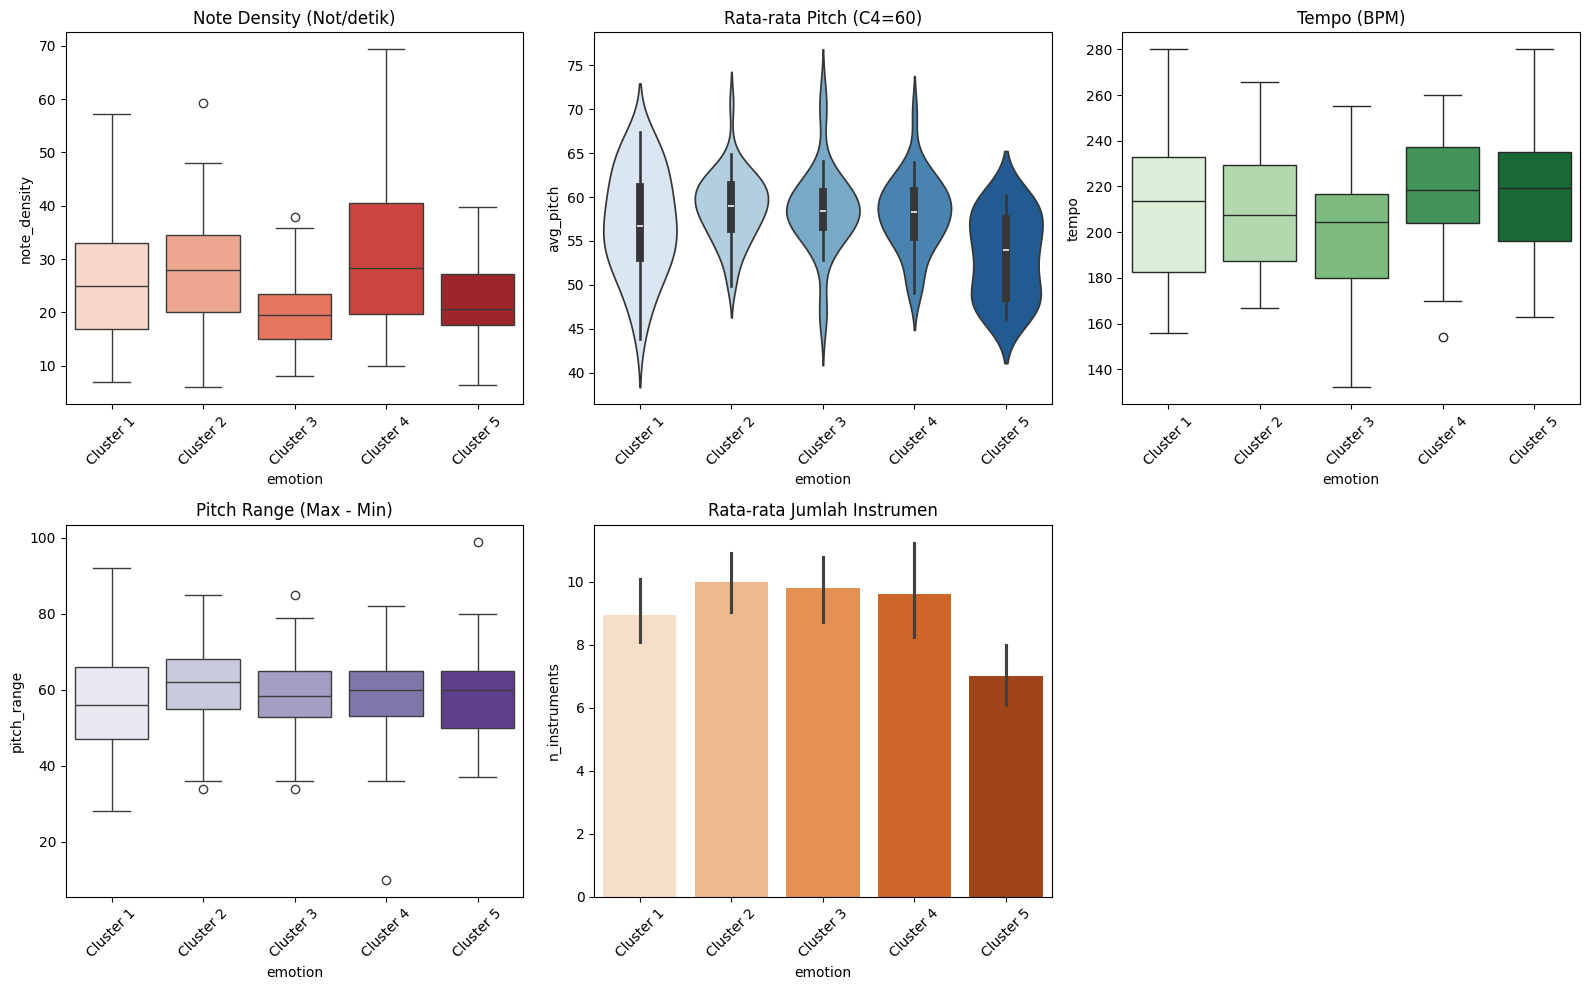

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

if not df_midi_eda.empty:
    order_cls = sorted(df_midi_eda['emotion'].unique())

    plt.figure(figsize=(16, 10))

    # 1. Note Density (Intensitas)
    # Hipotesis: Cluster 1 & 5 (Energi tinggi) harusnya punya density tinggi
    plt.subplot(2, 3, 1)
    sns.boxplot(x='emotion', y='note_density', data=df_midi_eda, order=order_cls, palette='Reds')
    plt.title('Note Density (Not/detik)')
    plt.xticks(rotation=45)

    # 2. Average Pitch (Tinggi Nada)
    # Hipotesis: Lagu Sedih (Cluster 3) mungkin lebih rendah?
    plt.subplot(2, 3, 2)
    sns.violinplot(x='emotion', y='avg_pitch', data=df_midi_eda, order=order_cls, palette='Blues')
    plt.title('Rata-rata Pitch (C4=60)')
    plt.xticks(rotation=45)

    # 3. Tempo
    plt.subplot(2, 3, 3)
    sns.boxplot(x='emotion', y='tempo', data=df_midi_eda, order=order_cls, palette='Greens')
    plt.title('Tempo (BPM)')
    plt.xticks(rotation=45)

    # 4. Pitch Range (Ambitus)
    # Lagu ekspresif biasanya range-nya lebar
    plt.subplot(2, 3, 4)
    sns.boxplot(x='emotion', y='pitch_range', data=df_midi_eda, order=order_cls, palette='Purples')
    plt.title('Pitch Range (Max - Min)')
    plt.xticks(rotation=45)

    # 5. Jumlah Instrumen (Kompleksitas)
    plt.subplot(2, 3, 5)
    sns.barplot(x='emotion', y='n_instruments', data=df_midi_eda, order=order_cls, palette='Oranges')
    plt.title('Rata-rata Jumlah Instrumen')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada data MIDI untuk divisualisasikan.")

## Piano Roll & Analisis Harmoni (D & E)

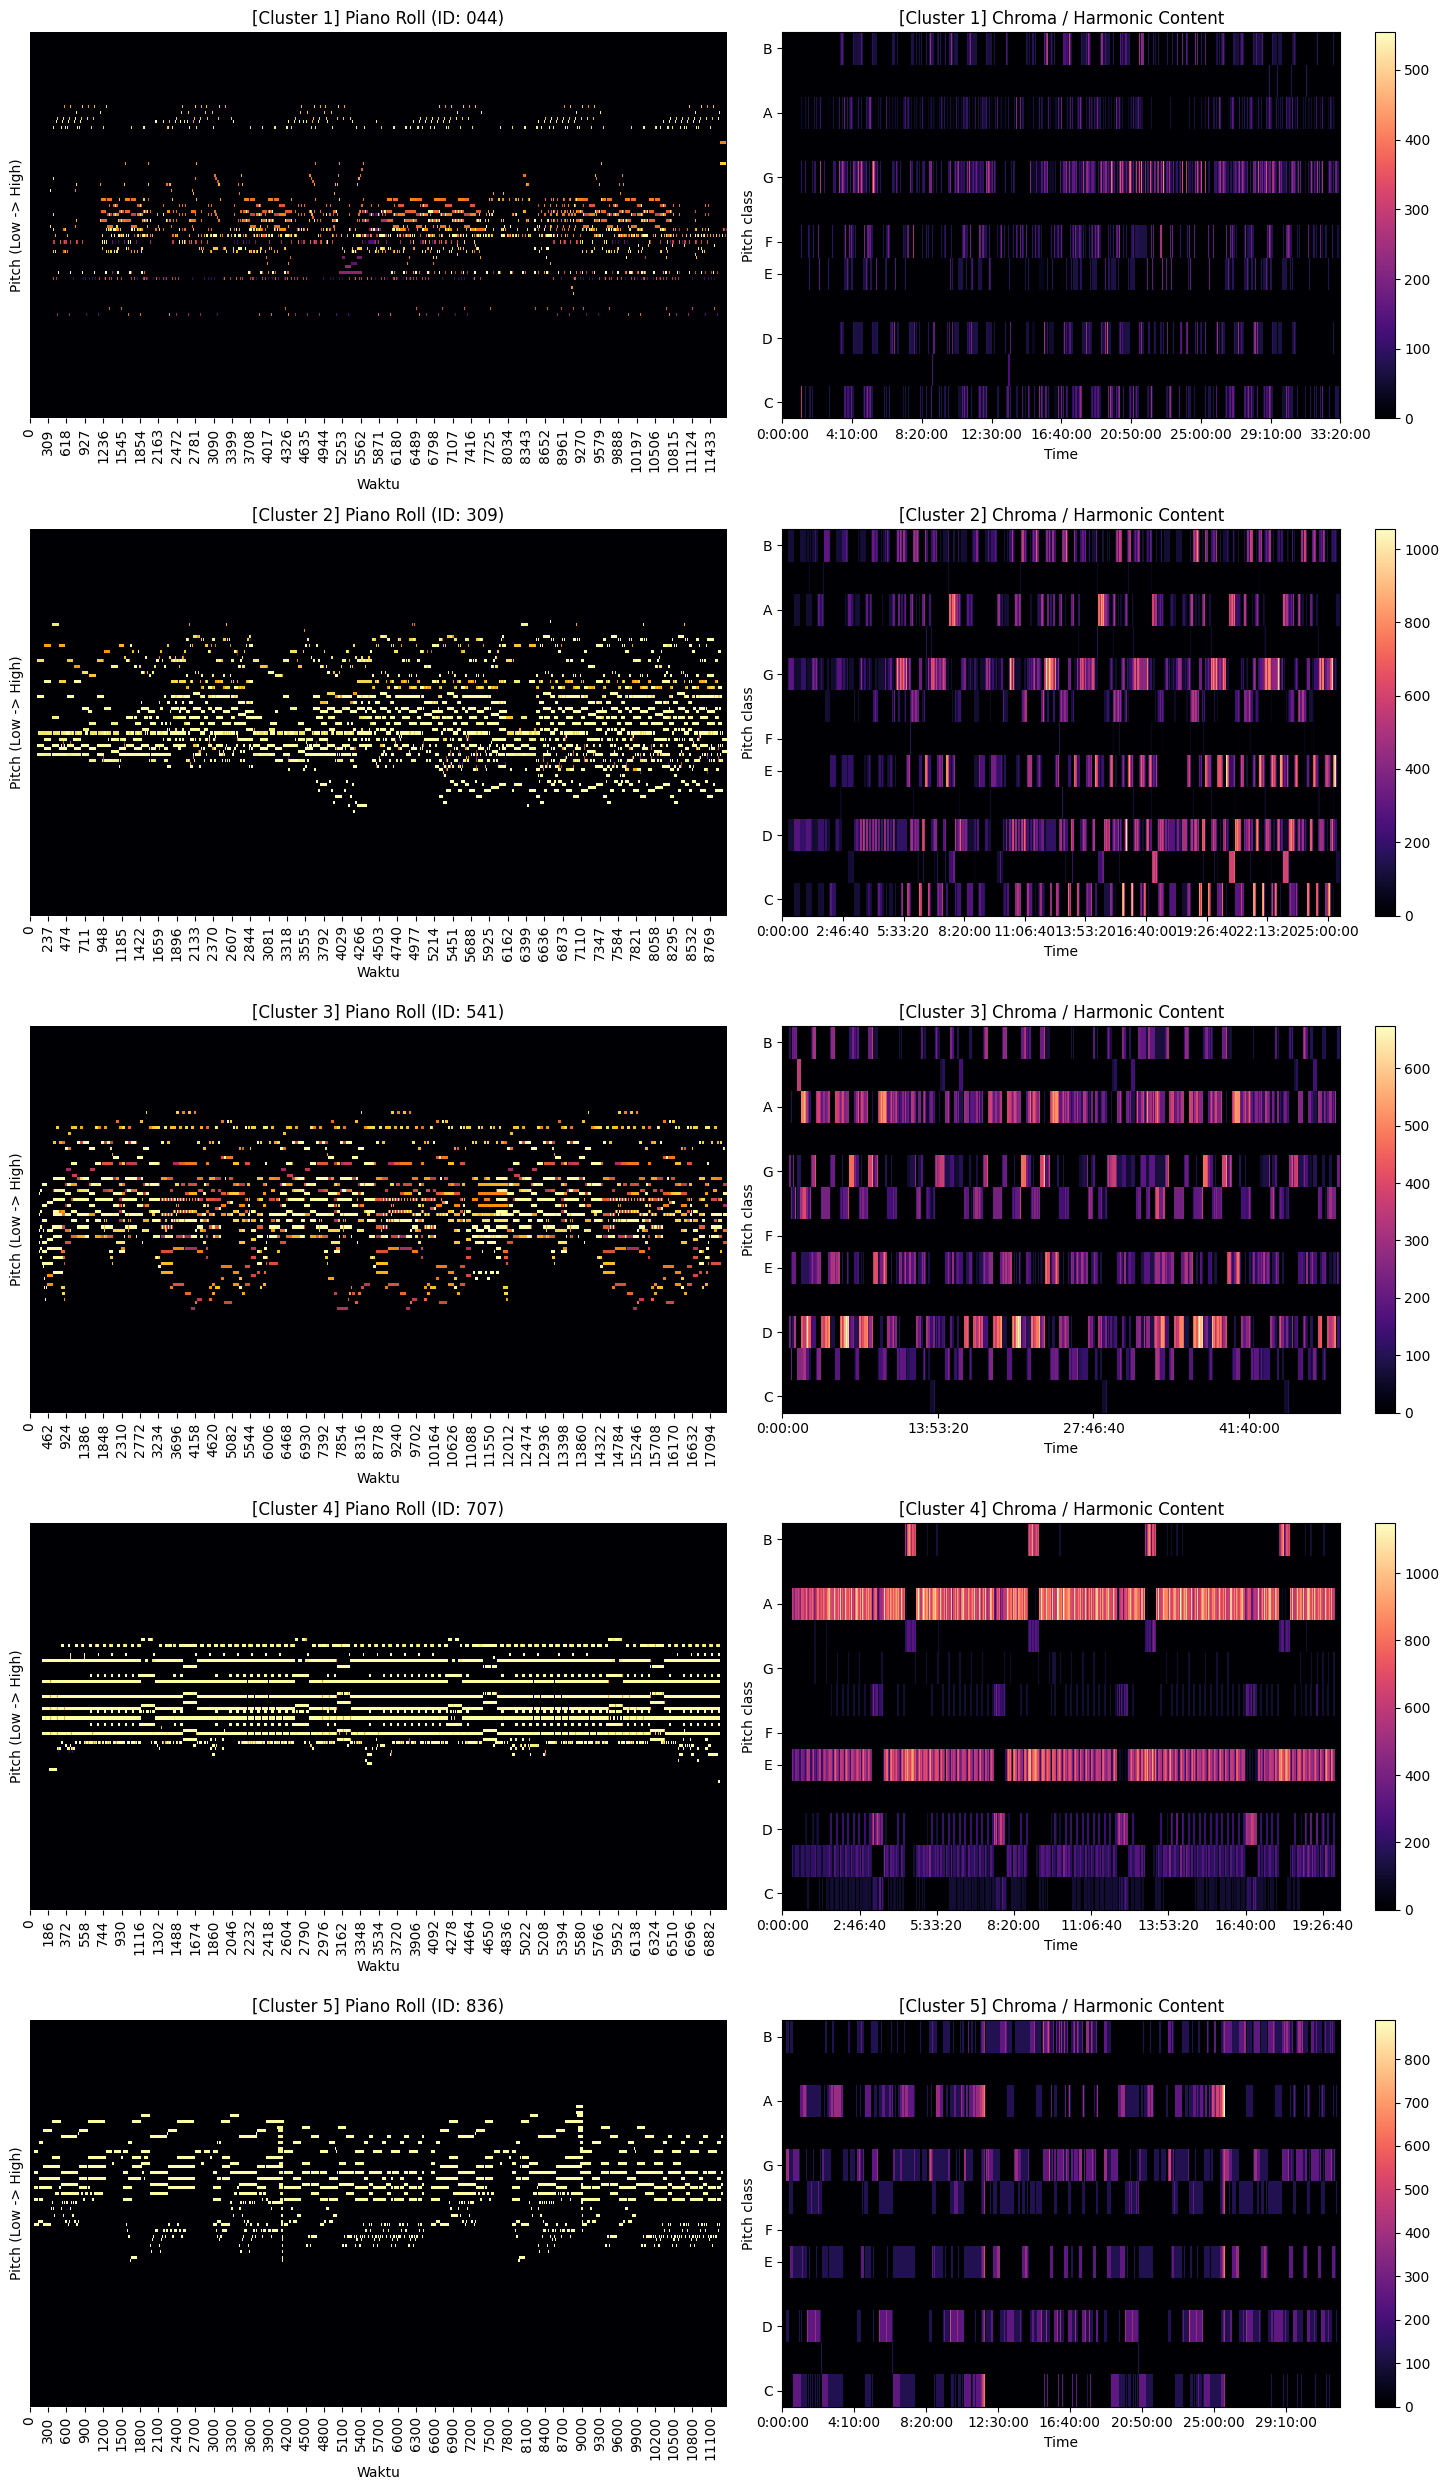

In [ ]:
import librosa.display

# Ambil 1 sampel per Cluster
unique_clusters = sorted(df_midi_eda['emotion'].unique())

plt.figure(figsize=(15, 5 * len(unique_clusters)))

for i, cluster in enumerate(unique_clusters):
    # Ambil sampel acak
    row = df_midi_eda[df_midi_eda['emotion'] == cluster].sample(1).iloc[0]
    fid = row['file_id']
    path = os.path.join(PATH_MIDI, f"{fid}.mid")

    try:
        pm = pretty_midi.PrettyMIDI(path)

        # 1. Piano Roll (Visualisasi Melodi & Ritme)
        # fs=50 artinya resolusi 50 pixel per detik
        piano_roll = pm.get_piano_roll(fs=50)

        # Plot Piano Roll
        plt.subplot(len(unique_clusters), 2, 2*i + 1)
        sns.heatmap(piano_roll, cmap='inferno', cbar=False, yticklabels=False, vmin=0, vmax=100)
        plt.title(f'[{cluster}] Piano Roll (ID: {fid})')
        plt.xlabel('Waktu')
        plt.ylabel('Pitch (Low -> High)')

        # 2. Chroma / Pitch Class (Visualisasi Harmoni)
        # Menunjukkan not apa yang paling dominan (C, C#, D, ...)
        chroma = pm.get_chroma(fs=50)

        plt.subplot(len(unique_clusters), 2, 2*i + 2)
        librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr=50)
        plt.title(f'[{cluster}] Chroma / Harmonic Content')
        plt.colorbar()

    except Exception as e:
        print(f"Gagal visualisasi {fid}: {e}")

plt.tight_layout()
plt.show()